#### DA6213
#### Exercise #2
#### Name: ___Dan Schumacher___

__Having talked about privacy and big data, let’s see how US adult consumers feel about it.  This exercise utilizes the 2015 National Consumer Survey.  The data is available in Excel, SPSS and SAS formats.  You should be able to get at it from one of these forms and move it to whatever platform you want.  Here are the instructions for this exercise.__

___imports___

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from IPython.display import IFrame

# my own functions
from functions.home_brew import (
    evaluate,
    diagnostic_plots,
    calculate_vif,
    remove_high_vif_features,
    plot_sensitivity_specificity,
    aic_scorer,
    select_model_by_aic,
    calculate_cooks_distance,
    logistic_regression_diagnostic_plots,
    view_logistic_regression_coefficients
)

___Load and peek at data___

In [32]:
privacy_df = pd.read_excel('./data/privacy.xlsx')

In [33]:
# this will look better
gender_map = {1: 'Male', 0: 'Female'}
privacy_df['gender'] = privacy_df['gender'].map(gender_map)

coke_map = {1: 'Drink Coke', 0: 'No Coke'}
privacy_df['classic_coke'] = privacy_df['classic_coke'].map(coke_map)

In [34]:
privacy_df.head()

,commodity,like_know,classic_coke,gender
0,1.0,4.0,No Coke,Female
1,3.0,4.0,Drink Coke,Female
2,2.0,3.0,Drink Coke,Female
3,4.0,5.0,Drink Coke,Female
4,4.0,4.0,Drink Coke,Male


In [35]:
privacy_df.shape

(25439, 4)

In [36]:
privacy_df.head(1)

,commodity,like_know,classic_coke,gender
0,1.0,4.0,No Coke,Female


In [37]:
privacy_df.columns

Index(['commodity', 'like_know', 'classic_coke', 'gender'], dtype='object')

In [38]:
privacy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25439 entries, 0 to 25438
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   commodity     23747 non-null  float64
 1   like_know     23752 non-null  float64
 2   classic_coke  25439 non-null  object 
 3   gender        25439 non-null  object 
dtypes: float64(2), object(2)
memory usage: 795.1+ KB


### 1.	Create a bar graph that displays the data for the variable commodity – this variable represents how consumers feel about their willingness to provide personal data for something of value.  What does the bar graph tell you in general?

- This Bar graph shows us that most people have a mid to high willingness to provide their personal data in exchange for something of value. (Most frequent are commodity rating 3 and 4)

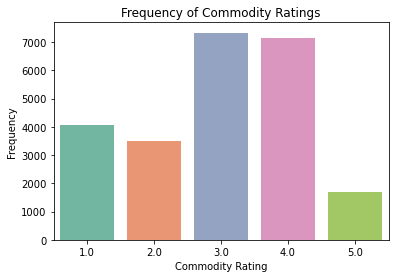

In [39]:
sns.countplot(x='commodity',data=privacy_df, palette='Set2')
plt.title('Frequency of Commodity Ratings')
plt.xlabel('Commodity Rating')
plt.ylabel('Frequency')
plt.show()

### 2.	Create a bar graph that displays the data for the variable like_know – this variable represents the extent to which consumers would like to know how their data is being used.  What does the bar graph tell you in general?

- This graph shows us that most everyone wants to know how their data is being used. Very few people (1s and 2s) don't seem to mind very much.

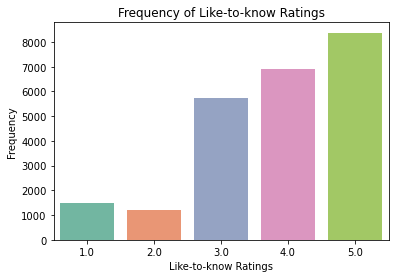

In [40]:
sns.countplot(x='like_know',data=privacy_df, palette='Set2')
plt.title('Frequency of Like-to-know Ratings')
plt.xlabel('Like-to-know Ratings')
plt.ylabel('Frequency')
plt.show()

### 3.	Perform the appropriate statistical test to see whether or not men and women differ in terms of how they feel about exchanging their personal data for something of value.  Interpret what you found – be sure to comment on the magnitude of any differences you find.


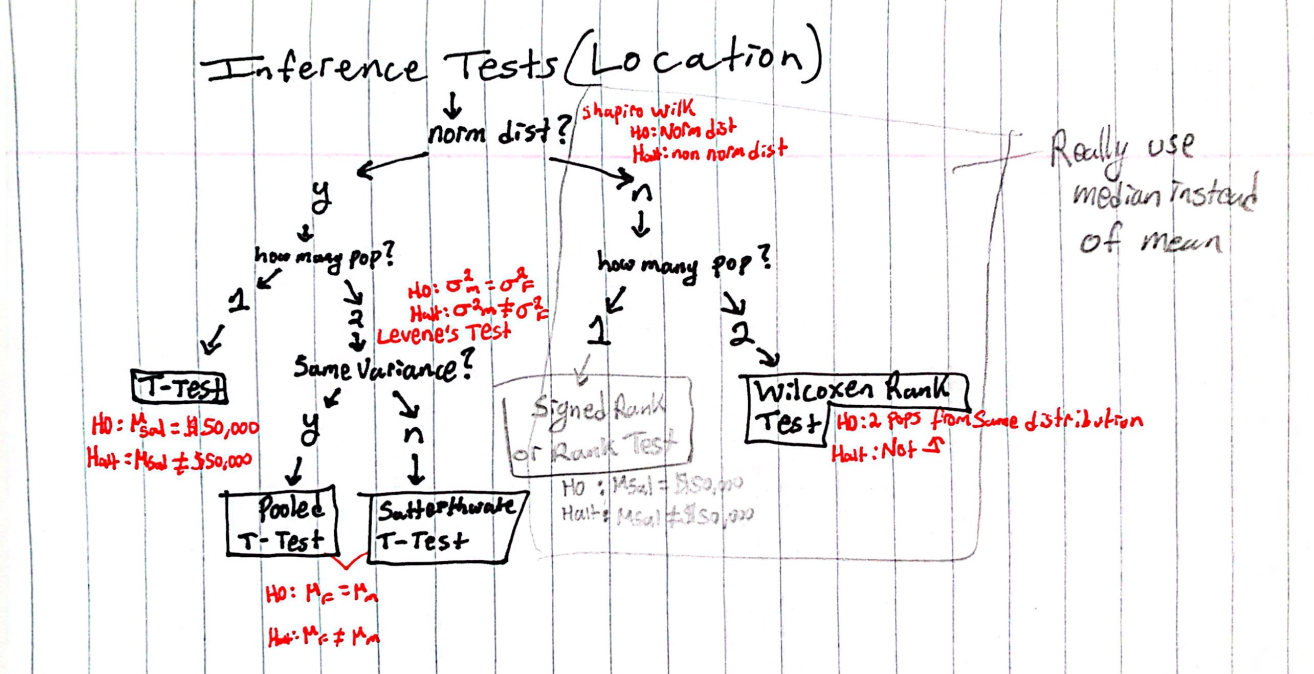

In [57]:
from IPython.display import Image

# Display an image with its filename
Image(filename='./data/inf_test.png')

___prepare data for tests___

In [42]:
# drop missing values.
privacy_df = privacy_df.dropna()
# shuffle the dataframe to insure it isn't ordered in a weird way
privacy_df = privacy_df.sample(frac=1, random_state=27).reset_index(drop=True)

In [43]:
#set seed for reproducibility
np.random.seed(27)

# grab just women
women = privacy_df[privacy_df['gender'] == 'Female']['commodity']
# sample random indexes
wom_indx = np.random.randint(0, women.shape[0], 5000)
# use those indexes to make a sampled dataframe
women_samp = women.iloc[wom_indx]

# REPEAT STEPS WITH MEN

men = privacy_df[privacy_df['gender'] == 'Male']['commodity']
men_indx = np.random.randint(0, men.shape[0], 5000)
men_samp = men.iloc[men_indx]

##### __check for normality__

In [44]:
# Shapiro-Wilk Test: WOMEN

print('NULL: WOMAN data comes from normaly distribution')

stat, p = stats.shapiro(women_samp)
print(f'Statistics={stat:.3f}, p={p:.3f}')

# Interpret
alpha = 0.05
if p > alpha:
    print('fail to reject H0: continue assuming normality')
else:
    print('reject H0: continue assuming non-normality')

NULL: WOMAN data comes from normaly distribution
Statistics=0.892, p=0.000
reject H0: continue assuming non-normality


In [45]:
# Shapiro-Wilk Test: MEN
print('NULL: MEN data comes from normal distribution')

stat, p = stats.shapiro(men_samp)
print(f'Statistics={stat:.3f}, p={p:.3}')


# Interpret
alpha = 0.05
if p > alpha:
    print('fail to reject H0: continue assuming normality')
else:
    print('reject H0: continue assuming non-normality')

NULL: MEN data comes from normal distribution
Statistics=0.889, p=0.0
reject H0: continue assuming non-normality


 ___Check for equal variance___

In [46]:
from scipy.stats import levene

# Perform Levene's test
statistic, p_value = levene(men_samp, women_samp)

# Print results
print(f"Levene's test statistic: {statistic:.3f}")
print(f"P-value: {p_value:.3}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis: The variances are significantly different.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in variances.")


Levene's test statistic: 5.079
P-value: 0.0242
Reject the null hypothesis: The variances are significantly different.


##### Run Wilcoxen Rank Test (because non-normality and unequal variance)

In [47]:
from scipy.stats import mannwhitneyu

print('Null: Men and Women are from the same distribution')

statistic, p_value = mannwhitneyu(men, women)

# Print the results
print(f"Mann-Whitney U test statistic: {statistic:.3}")
print(f"P-value: {p_value:.3}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis: The two men and women come from different distributions.")
else:
    print("Fail to reject the null hypothesis: There is no evidence that populations have different distributions.")


Null: Men and Women are from the same distribution
Mann-Whitney U test statistic: 7.06e+07
P-value: 1.91e-06
Reject the null hypothesis: The two men and women come from different distributions.


#### determine magnitude

In [48]:
np.median(men) - np.median(women)

0.0

In [49]:
np.mean(men) - np.mean(women)

0.07717363348359418

- Even though there is a statistical significance the means are so close together that it doesn't really matter...

### 4.	Perform the appropriate statistical test to see whether or not people who drink coca cola differ in terms of how they feel about knowing how their data is being used.    Interpret what you found – be sure to comment on the magnitude of any differences you find.

___set up for test___

In [50]:
coke_df = privacy_df[privacy_df['classic_coke'] == 'Drink Coke']
no_coke_df = privacy_df[privacy_df['classic_coke'] == 'No Coke']

In [51]:
#set seed for reproducibility
np.random.seed(27)

# grab just coke
coke = privacy_df[privacy_df['classic_coke'] == 'Drink Coke']['like_know']
# sample random indexes
coke_indx = np.random.randint(0, women.shape[0], 5000)
# use those indexes to make a sampled dataframe
coke_samp = women.iloc[wom_indx]

# REPEAT STEPS WITH NON-COKE

no_coke = privacy_df[privacy_df['classic_coke'] == 'No Coke']['like_know']
no_coke_indx = np.random.randint(0, men.shape[0], 5000)
no_coke_samp = men.iloc[men_indx]

___check for normality___

In [52]:
# Shapiro-Wilk Test: COKE

print('NULL: COKE data comes from normaly distribution')

stat, p = stats.shapiro(coke_samp)
print(f'Statistics={stat:.3f}, p={p:.3f}')

# Interpret
alpha = 0.05
if p > alpha:
    print('fail to reject H0: continue assuming normality')
else:
    print('reject H0: continue assuming non-normality')

NULL: COKE data comes from normaly distribution
Statistics=0.892, p=0.000
reject H0: continue assuming non-normality


In [53]:
# Shapiro-Wilk Test: NO-COKE

print('NULL: NO-COKE data comes from normaly distribution')

stat, p = stats.shapiro(no_coke_samp)
print(f'Statistics={stat:.3f}, p={p:.3f}')

# Interpret
alpha = 0.05
if p > alpha:
    print('fail to reject H0: continue assuming normality')
else:
    print('reject H0: continue assuming non-normality')

NULL: NO-COKE data comes from normaly distribution
Statistics=0.889, p=0.000
reject H0: continue assuming non-normality


___Run Wilcoxen Rank Test (because non-normality and 2 groups)___

In [54]:
print('Null: Coke and No-Coke are from the same distribution')

statistic, p_value = mannwhitneyu(coke, no_coke)

# Print the results
print(f"Mann-Whitney U test statistic: {statistic:.3}")
print(f"P-value: {p_value:.3}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis: The coke and no-coke groups come from different distributions.")
else:
    print("Fail to reject the null hypothesis: There is no evidence that populations have different distributions.")


Null: Coke and No-Coke are from the same distribution
Mann-Whitney U test statistic: 5.75e+07
P-value: 0.00115
Reject the null hypothesis: The coke and no-coke groups come from different distributions.


In [56]:
np.median(coke) - np.median(no_coke)

0.0

In [55]:
np.mean(coke) - np.mean(no_coke)

-0.03914883864047569

- Again, even though there is a statistical significance the means are so close together that it doesn't really matter...